### Setup & Synthetic "Obstacle" Data

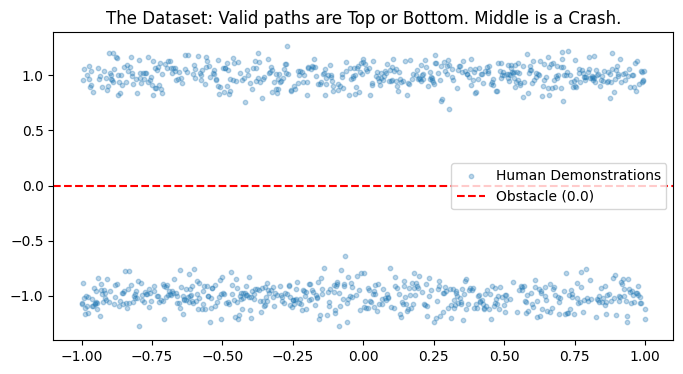

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup the Data (The "Pole" Problem)
# Scenario: A robot sees an obstacle.
# Human Demonstrations: 50% steer LEFT (+1), 50% steer RIGHT (-1).
# We add some noise to simulate real human imperfection.

n_samples = 1000

# Input state (x): Just a dummy feature (e.g., "distance to pole")
# We keep it simple to visualize 1D distribution
x_train = torch.linspace(-1, 1, n_samples).unsqueeze(1)

# Target action (y): Bimodal distribution
# Half the data is roughly +1, Half is roughly -1
y_train = torch.zeros(n_samples, 1)
noise = torch.randn(n_samples, 1) * 0.1

# Assign modes
for i in range(n_samples):
    if np.random.rand() > 0.5:
        y_train[i] = 1.0 + noise[i] # Mode A: Steer Left
    else:
        y_train[i] = -1.0 + noise[i] # Mode B: Steer Right

# Visualization of the Dataset
plt.figure(figsize=(8, 4))
plt.scatter(x_train, y_train, alpha=0.3, s=10, label='Human Demonstrations')
plt.axhline(0, color='red', linestyle='--', label='Obstacle (0.0)')
plt.title("The Dataset: Valid paths are Top or Bottom. Middle is a Crash.")
plt.legend()
plt.show()

### Point-Estimate Policy

In [2]:
# 2. Train a Point-Estimate Policy (Standard Regression)
# Model: Simple MLP
# Loss: Mean Squared Error (MSE)

model_mse = nn.Sequential(
    nn.Linear(1, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1) # Outputs a single scalar (Point Estimate)
)

optimizer = optim.Adam(model_mse.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training Loop
for epoch in range(500):
    optimizer.zero_grad()
    y_pred = model_mse(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

# Predict
with torch.no_grad():
    y_pred_mse = model_mse(x_train)

print(f"Final MSE Loss: {loss.item():.4f}")
print("Training complete. Notice where the predictions land in the next plot.")

Final MSE Loss: 1.0012
Training complete. Notice where the predictions land in the next plot.


### Multimodal Policy - Mixture Density Network

In [3]:
# 3. Train a Multimodal Policy (Mixture Density Network)
# Model: Outputs parameters for 2 Gaussians (Means, Sigmas, Pis)

class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians) # Mixing coefficients
        self.z_sigma = nn.Linear(n_hidden, n_gaussians) # Standard deviations
        self.z_mu = nn.Linear(n_hidden, n_gaussians) # Means

    def forward(self, x):
        z = self.z_h(x)
        pi = torch.softmax(self.z_pi(z), -1)       # Softmax so sum(pi)=1
        sigma = torch.exp(self.z_sigma(z))         # Exp so sigma > 0
        mu = self.z_mu(z)
        return pi, sigma, mu

# Custom Loss Function: Negative Log Likelihood of GMM
def mdn_loss(pi, sigma, mu, y):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    # Expand y to match number of gaussians
    y = y.expand_as(mu)
    prob = m.log_prob(y)
    # Log-Sum-Exp trick for numerical stability
    loss = -torch.logsumexp(torch.log(pi) + prob, dim=1)
    return torch.mean(loss)

model_mdn = MDN(n_hidden=64, n_gaussians=2)
optimizer_mdn = optim.Adam(model_mdn.parameters(), lr=0.005)

# Training Loop
for epoch in range(1000):
    optimizer_mdn.zero_grad()
    pi, sigma, mu = model_mdn(x_train)
    loss = mdn_loss(pi, sigma, mu, y_train)
    loss.backward()
    optimizer_mdn.step()

print(f"Final MDN Loss: {loss.item():.4f}")

Final MDN Loss: -0.2502


### Comparisons and Visualizations

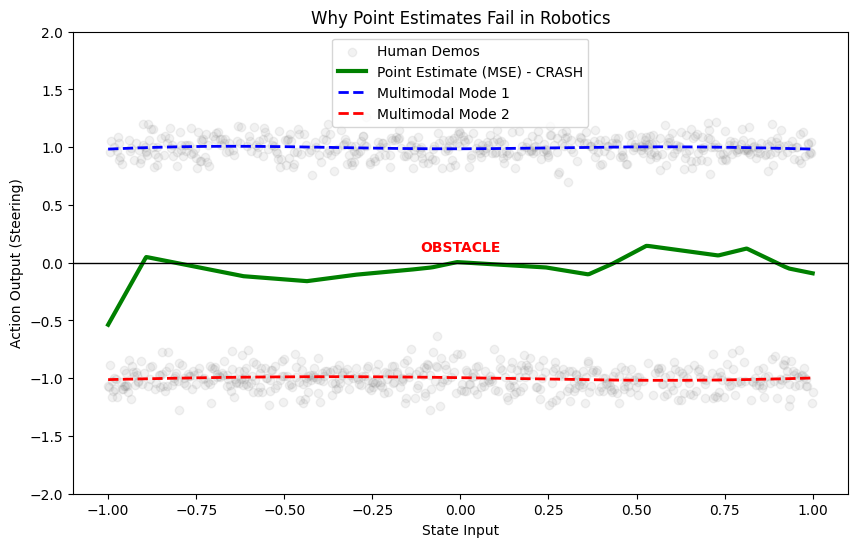

In [4]:
# 4. Visualization and Comparison

plt.figure(figsize=(10, 6))

# Plot Original Data
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.1, color='gray', label='Human Demos')

# Plot Point Estimate (MSE)
plt.plot(x_train.numpy(), y_pred_mse.numpy(), color='green', linewidth=3, label='Point Estimate (MSE) - CRASH')

# Plot Multimodal (MDN)
# We sample from the learned distribution to show valid paths
with torch.no_grad():
    pi, sigma, mu = model_mdn(x_train)
    # Get the most likely modes
    mean_1 = mu[:, 0].numpy()
    mean_2 = mu[:, 1].numpy()

plt.plot(x_train.numpy(), mean_1, 'b--', linewidth=2, label='Multimodal Mode 1')
plt.plot(x_train.numpy(), mean_2, 'r--', linewidth=2, label='Multimodal Mode 2')

# Annotations
plt.axhline(0, color='black', linewidth=1, linestyle='-')
plt.text(0, 0.1, "OBSTACLE", ha='center', color='red', weight='bold')

plt.title("Why Point Estimates Fail in Robotics")
plt.legend()
plt.ylim(-2, 2)
plt.xlabel("State Input")
plt.ylabel("Action Output (Steering)")
plt.show()